In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
%matplotlib inline
_key = '16effcabd5d51ae74821b3639db3844d8c7f1beb'
_url = f'https://api.census.gov/data/2018/abscs?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,SEX,SEX_LABEL,ETH_GROUP,ETH_GROUP_LABEL,RACE_GROUP,RACE_GROUP_LABEL,VET_GROUP,VET_GROUP_LABEL,EMPSZFI,EMPSZFI_LABEL,YEAR,FIRMPDEMP,FIRMPDEMP_F,RCPPDEMP,RCPPDEMP_F,EMP,EMP_F,PAYANN,PAYANN_F,FIRMPDEMP_S,FIRMPDEMP_S_F,RCPPDEMP_S,RCPPDEMP_S_F,EMP_S,EMP_S_F,PAYANN_S,PAYANN_S_F&for=us:*&key={_key}'
r = requests.get(_url).json()
print(r)


: 

In [ ]:
filename = 'census_data_2018.json'
with open(filename,'wt') as census:
    json.dump(r, census)

# Creates dataframe from json file
census_df = pd.read_json(filename)

# Renames the headers
census_df.rename(columns=census_df.iloc[0],inplace=True)
census_df.drop(0,inplace=True)
census_df

In [ ]:
#drop unnecessary columns
census_df_dropped = census_df.drop(columns=['us','NAICS2017','SEX','GEO_ID','ETH_GROUP','RACE_GROUP','EMP_F','FIRMPDEMP_F','VET_GROUP','EMP_S','FIRMPDEMP_S','FIRMPDEMP_S_F','PAYANN_S','RCPPDEMP_S','RCPPDEMP_F','RCPPDEMP_S_F','EMP_S_F','PAYANN_S_F','PAYANN_F'],axis=1)

In [ ]:
#filter out only male/female values
census_df_emp_filtered = census_df_dropped[(census_df_dropped['EMPSZFI_LABEL']!='All firms') & (census_df_dropped['EMPSZFI_LABEL']!='Firms with no employees')]

census_df_filtered_male = census_df_emp_filtered[census_df_emp_filtered['SEX_LABEL'] == 'Male']
census_df_filtered_female = census_df_emp_filtered[census_df_emp_filtered['SEX_LABEL'] == 'Female']
#group by EMPSZFI_Label, return the values in numpy array
census_df_emp_sex_male = census_df_filtered_male.groupby('EMPSZFI_LABEL').agg({'SEX_LABEL':'value_counts'})['SEX_LABEL'].values
census_df_emp_sex_female = census_df_filtered_female.groupby('EMPSZFI_LABEL').agg({'SEX_LABEL':'value_counts'})['SEX_LABEL'].values
census_df_emp = census_df_emp_filtered['EMPSZFI_LABEL'].unique()

In [ ]:
#filter out by ethnicity
census_df_filtered_hispanic = census_df_emp_filtered[census_df_dropped['ETH_GROUP_LABEL']=='Hispanic']
census_df_filtered_nohispanic = census_df_emp_filtered[census_df_dropped['ETH_GROUP_LABEL']=='Non-Hispanic']
#group by ethnicity, return the values in numpy array
census_df_emp_eth_hispanic = census_df_filtered_hispanic.groupby('EMPSZFI_LABEL').agg({'ETH_GROUP_LABEL':'value_counts'})['ETH_GROUP_LABEL'].values
census_df_emp_eth_nohispanic = census_df_filtered_nohispanic.groupby('EMPSZFI_LABEL').agg({'ETH_GROUP_LABEL':'value_counts'})['ETH_GROUP_LABEL'].values

/var/folders/1m/cryjf7b56hj14d537cgrgjhw0000gn/T/ipykernel_35428/2875195943.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  census_df_filtered_hispanic = census_df_emp_filtered[census_df_dropped['ETH_GROUP_LABEL']=='Hispanic']
/var/folders/1m/cryjf7b56hj14d537cgrgjhw0000gn/T/ipykernel_35428/2875195943.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  census_df_filtered_nohispanic = census_df_emp_filtered[census_df_dropped['ETH_GROUP_LABEL']=='Non-Hispanic']


In [ ]:
census_df_emp_filtered.info()
census_df_emp_filtered['RCPPDEMP'] = census_df_emp_filtered.RCPPDEMP.astype(int)
census_df_emp_sales = census_df_emp_filtered.groupby('EMPSZFI_LABEL').agg({'RCPPDEMP':'mean'})['RCPPDEMP'].values/1000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13191 entries, 3 to 19458
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   NAME              13191 non-null  object
 1   NAICS2017_LABEL   13191 non-null  object
 2   SEX_LABEL         13191 non-null  object
 3   ETH_GROUP_LABEL   13191 non-null  object
 4   RACE_GROUP_LABEL  13191 non-null  object
 5   VET_GROUP_LABEL   13191 non-null  object
 6   EMPSZFI           13191 non-null  object
 7   EMPSZFI_LABEL     13191 non-null  object
 8   YEAR              13191 non-null  object
 9   FIRMPDEMP         13191 non-null  object
 10  RCPPDEMP          13191 non-null  int64 
 11  EMP               13191 non-null  object
 12  PAYANN            13191 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.4+ MB


/var/folders/1m/cryjf7b56hj14d537cgrgjhw0000gn/T/ipykernel_35428/4083409443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_df_emp_filtered['RCPPDEMP'] = census_df_emp_filtered.RCPPDEMP.astype(int)


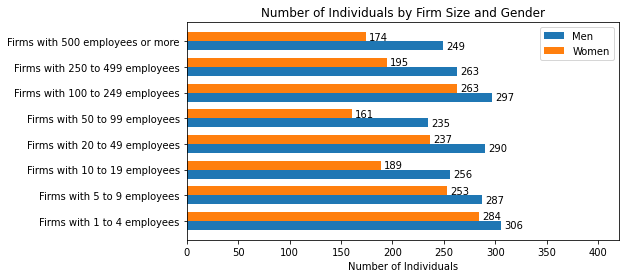

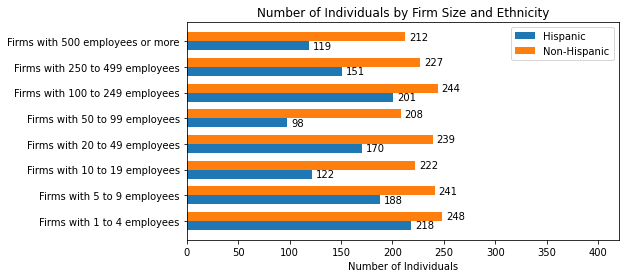

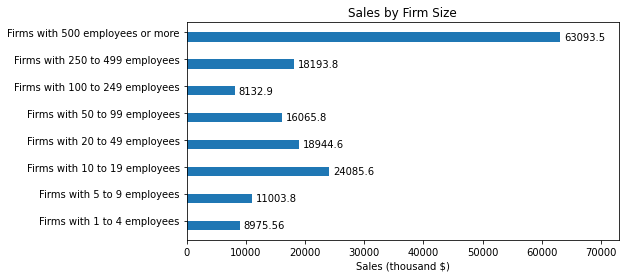

In [ ]:
#configure plot

x = np.arange(len(census_df_emp))  # the label locations
width = 0.35  # the width of the bars
#configure plot
fig,ax = plt.subplots()
rects1 = ax.barh(x - width/2, census_df_emp_sex_male, width, label='Men')
rects2 = ax.barh(x + width/2, census_df_emp_sex_female, width, label='Women')
#set labels
ax.set_xlabel('Number of Individuals')
ax.set_title('Number of Individuals by Firm Size and Gender')
#set legend location
ax.legend(loc=0)
#set y axis limit
ax.set_xlim([0, 420])
ax.set_yticks(x,census_df_emp)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
#make graph wider
fig.subplots_adjust(left=2,right=3)

fig2,ax2 = plt.subplots()
rects1 = ax2.barh(x - width/2, census_df_emp_eth_hispanic, width, label='Hispanic')
rects2 = ax2.barh(x + width/2, census_df_emp_eth_nohispanic, width, label='Non-Hispanic')
#set labels
ax2.set_xlabel('Number of Individuals')
ax2.set_title('Number of Individuals by Firm Size and Ethnicity')
#set legend location
ax2.legend(loc=0)
#set y axis limit
ax2.set_xlim([0, 420])
ax2.set_yticks(x,census_df_emp)
ax2.bar_label(rects1, padding=4)
ax2.bar_label(rects2, padding=4)
#make graph wider
fig2.subplots_adjust(left=2,right=3)
plt.show()

fig3,ax3 = plt.subplots()
rects1 = ax3.barh(x - width/2, census_df_emp_sales, width, label='Annual Sale')
#set labels
ax3.set_xlabel('Sales (thousand $)')
ax3.set_title('Sales by Firm Size')
ax3.set_xlim([0,73000])
#set legend location
#set y axis limit
ax3.set_yticks(x,census_df_emp)
ax3.bar_label(rects1, padding=4)
#make graph wider
fig3.subplots_adjust(left=2,right=3)
plt.show()